In [1]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -O /tmp/bbc-text.csv

--2020-12-09 18:35:56--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 74.125.24.128, 2404:6800:4003:c04::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [application/octet-stream]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.05s   

2020-12-09 18:35:56 (105 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



In [2]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [3]:
sentences = []
labels = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
print(len(stopwords))

153


In [4]:
with open("/tmp/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        sentence = row[1]
        for word in stopwords:
            token = " " + word + " "
            sentence = sentence.replace(token, " ")
        sentences.append(sentence)

print(len(labels))
print(len(sentences))
print(sentences[0])

2225
2225
tv future hands viewers home theatre systems  plasma high-definition tvs  digital video recorders moving living room  way people watch tv will radically different five years  time.  according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes. us leading trend  programmes content will delivered viewers via home networks  cable  satellite  telecoms companies  broadband service providers front rooms portable devices.  one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes  like us s tivo uk s sky+ system  allow people record  store  play  pause forward wind tv programmes want.  essentially  technology allows much personalised tv. also built-in high-definition tv sets  big business japan us  slower take off europe lack high-definition programming. not can people forward wind adverts  can also forget abiding network channel schedules  putting together a-la-carte entertai

In [5]:
train_size = int(len(sentences) * training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

1780
1780
1780
445
445


In [6]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

449
120
200
120
192
120


In [7]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

print(len(validation_sequences))
print(validation_padded.shape)

445
(445, 120)


In [8]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[4]
[2]
[1]
(1780, 1)
[5]
[4]
[3]
(445, 1)


In [9]:
model_64_dense = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model_64_dense.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_64_dense.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 150       
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [10]:
num_epochs = 30
history = model_64_dense.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/30
56/56 - 0s - loss: 1.7753 - accuracy: 0.2287 - val_loss: 1.7560 - val_accuracy: 0.2337
Epoch 2/30
56/56 - 0s - loss: 1.7231 - accuracy: 0.2466 - val_loss: 1.6890 - val_accuracy: 0.2629
Epoch 3/30
56/56 - 0s - loss: 1.6259 - accuracy: 0.3062 - val_loss: 1.5651 - val_accuracy: 0.3438
Epoch 4/30
56/56 - 0s - loss: 1.4559 - accuracy: 0.5348 - val_loss: 1.3679 - val_accuracy: 0.7236
Epoch 5/30
56/56 - 0s - loss: 1.2388 - accuracy: 0.6944 - val_loss: 1.1655 - val_accuracy: 0.6539
Epoch 6/30
56/56 - 0s - loss: 1.0297 - accuracy: 0.7517 - val_loss: 0.9845 - val_accuracy: 0.7348
Epoch 7/30
56/56 - 0s - loss: 0.8446 - accuracy: 0.8253 - val_loss: 0.8289 - val_accuracy: 0.7933
Epoch 8/30
56/56 - 0s - loss: 0.6912 - accuracy: 0.8685 - val_loss: 0.6979 - val_accuracy: 0.8674
Epoch 9/30
56/56 - 0s - loss: 0.5639 - accuracy: 0.9281 - val_loss: 0.5944 - val_accuracy: 0.8742
Epoch 10/30
56/56 - 0s - loss: 0.4608 - accuracy: 0.9444 - val_loss: 0.5070 - val_accuracy: 0.8921
Epoch 11/30
56/56 -

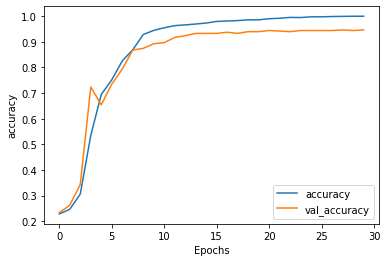

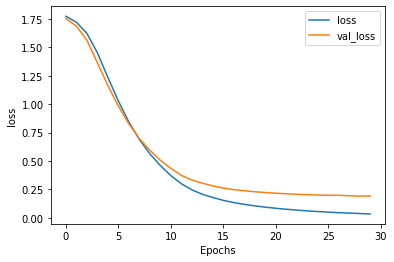

In [11]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [12]:
model_32_LSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(32),
    #tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model_32_LSTM.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_32_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
lstm (LSTM)                  (None, 32)                6272      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 22,470
Trainable params: 22,470
Non-trainable params: 0
_________________________________________________________________


In [13]:
history2 = model_32_LSTM.fit(train_padded, training_label_seq, epochs=60, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/60
56/56 - 1s - loss: 1.7134 - accuracy: 0.2410 - val_loss: 1.6154 - val_accuracy: 0.2270
Epoch 2/60
56/56 - 0s - loss: 1.5860 - accuracy: 0.2955 - val_loss: 1.4248 - val_accuracy: 0.4247
Epoch 3/60
56/56 - 0s - loss: 1.5229 - accuracy: 0.3747 - val_loss: 1.5349 - val_accuracy: 0.3146
Epoch 4/60
56/56 - 0s - loss: 1.5199 - accuracy: 0.3820 - val_loss: 1.6207 - val_accuracy: 0.3461
Epoch 5/60
56/56 - 0s - loss: 1.5151 - accuracy: 0.4034 - val_loss: 1.4621 - val_accuracy: 0.4427
Epoch 6/60
56/56 - 0s - loss: 1.2552 - accuracy: 0.5376 - val_loss: 1.2333 - val_accuracy: 0.5506
Epoch 7/60
56/56 - 0s - loss: 1.0462 - accuracy: 0.6337 - val_loss: 1.1215 - val_accuracy: 0.5506
Epoch 8/60
56/56 - 0s - loss: 0.8154 - accuracy: 0.6483 - val_loss: 0.8178 - val_accuracy: 0.6764
Epoch 9/60
56/56 - 0s - loss: 0.7044 - accuracy: 0.7213 - val_loss: 0.7528 - val_accuracy: 0.6899
Epoch 10/60
56/56 - 0s - loss: 0.6152 - accuracy: 0.7702 - val_loss: 0.7843 - val_accuracy: 0.6427
Epoch 11/60
56/56 -

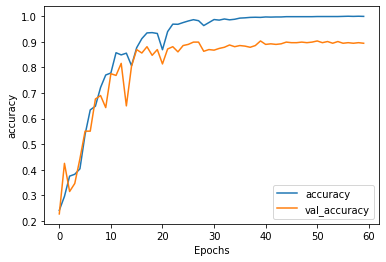

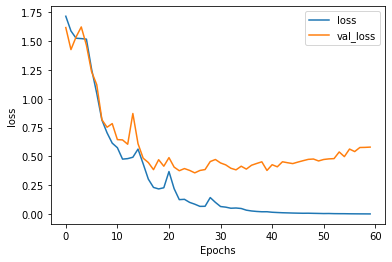

In [14]:
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")

In [15]:
model_lstm_conv1d = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(6, activation='softmax')
])
model_lstm_conv1d.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_lstm_conv1d.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
dropout (Dropout)            (None, 120, 16)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 64)           5184      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 29, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 54,598
Trainable params: 54,598
Non-trainable params: 0
__________________________________________________

In [16]:
history3 = model_lstm_conv1d.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/30
56/56 - 1s - loss: 1.6478 - accuracy: 0.2421 - val_loss: 1.5905 - val_accuracy: 0.2742
Epoch 2/30
56/56 - 0s - loss: 1.3476 - accuracy: 0.4124 - val_loss: 1.1095 - val_accuracy: 0.4607
Epoch 3/30
56/56 - 0s - loss: 0.9343 - accuracy: 0.5730 - val_loss: 0.9728 - val_accuracy: 0.5708
Epoch 4/30
56/56 - 0s - loss: 0.7382 - accuracy: 0.6899 - val_loss: 0.6031 - val_accuracy: 0.7551
Epoch 5/30
56/56 - 0s - loss: 0.4661 - accuracy: 0.8326 - val_loss: 0.5405 - val_accuracy: 0.8180
Epoch 6/30
56/56 - 0s - loss: 0.3166 - accuracy: 0.9034 - val_loss: 0.4267 - val_accuracy: 0.8449
Epoch 7/30
56/56 - 0s - loss: 0.2188 - accuracy: 0.9360 - val_loss: 0.3645 - val_accuracy: 0.8899
Epoch 8/30
56/56 - 0s - loss: 0.1709 - accuracy: 0.9506 - val_loss: 0.3963 - val_accuracy: 0.8719
Epoch 9/30
56/56 - 0s - loss: 0.1349 - accuracy: 0.9652 - val_loss: 0.4181 - val_accuracy: 0.8764
Epoch 10/30
56/56 - 0s - loss: 0.1201 - accuracy: 0.9674 - val_loss: 0.4026 - val_accuracy: 0.8764
Epoch 11/30
56/56 -

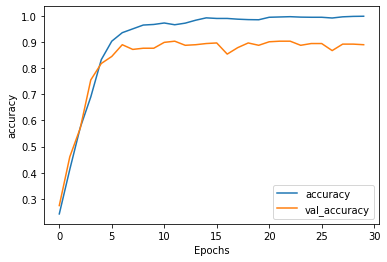

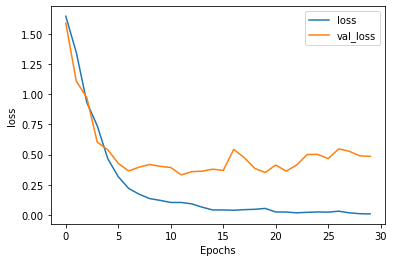

In [17]:
plot_graphs(history3, "accuracy")
plot_graphs(history3, "loss")

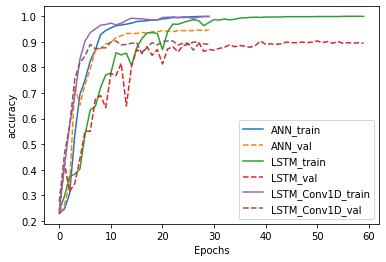

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_'+'accuracy'],'--')
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_'+'accuracy'],'--')
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_'+'accuracy'],'--')
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['ANN_train','ANN_val','LSTM_train','LSTM_val','LSTM_Conv1D_train','LSTM_Conv1D_val'])
plt.show()

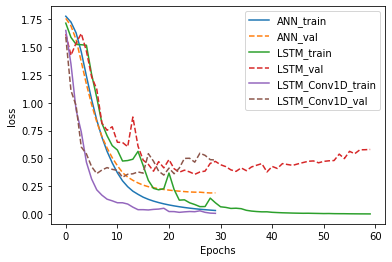

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_'+'loss'],'--')
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_'+'loss'],'--')
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_'+'loss'],'--')
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.legend(['ANN_train','ANN_val','LSTM_train','LSTM_val','LSTM_Conv1D_train','LSTM_Conv1D_val'])
plt.show()

In [21]:
x=model_64_dense.layers[0]
weight1=x.get_weights()[0]
y=model_32_LSTM.layers[0]
weight2=y.get_weights()[0]
z=model_lstm_conv1d.layers[0]
weight3=z.get_weights()[0]
print(weight1.shape)
print(weight2.shape)
print(weight3.shape)

(1000, 16)
(1000, 16)
(1000, 16)


In [ ]:
word_index.items()

dict_items([('<OOV>', 1), ('s', 2), ('said', 3), ('will', 4), ('not', 5), ('mr', 6), ('year', 7), ('also', 8), ('people', 9), ('new', 10), ('us', 11), ('one', 12), ('can', 13), ('last', 14), ('t', 15), ('first', 16), ('time', 17), ('two', 18), ('government', 19), ('world', 20), ('now', 21), ('uk', 22), ('best', 23), ('years', 24), ('no', 25), ('make', 26), ('just', 27), ('film', 28), ('told', 29), ('made', 30), ('get', 31), ('music', 32), ('game', 33), ('like', 34), ('back', 35), ('many', 36), ('000', 37), ('labour', 38), ('three', 39), ('well', 40), ('1', 41), ('next', 42), ('bbc', 43), ('take', 44), ('set', 45), ('number', 46), ('added', 47), ('way', 48), ('market', 49), ('2', 50), ('company', 51), ('may', 52), ('says', 53), ('election', 54), ('home', 55), ('off', 56), ('party', 57), ('good', 58), ('going', 59), ('much', 60), ('work', 61), ('2004', 62), ('still', 63), ('win', 64), ('show', 65), ('think', 66), ('games', 67), ('go', 68), ('top', 69), ('second', 70), ('won', 71), ('mill

In [22]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


In [23]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(a,b):
  return dot(a, b)/(norm(a)*norm(b))

def euc_dist(a,b):
  return np.linalg.norm(a-b)


In [ ]:
import pandas as pd
df=pd.DataFrame(weight1)

In [30]:
X_corr=df.corr()
values,vectors=np.linalg.eig(X_corr)
eigv_s=(-values).argsort()
vectors=vectors[:,eigv_s]
new_vectors=vectors[:,:2]
new_X=np.dot(weight1,new_vectors)

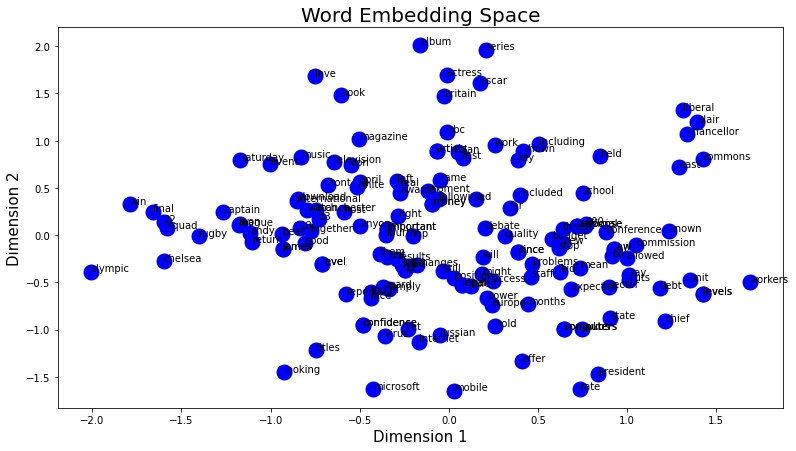

In [108]:
import matplotlib.pyplot as plt
vocab_word=list(word_index.keys())
vocab_word=vocab_word[:1000]
random_vocab=np.random.choice(vocab_word,150)
random_index=list(word_index[i] for i in random_vocab)
sampled_X=new_X[random_index,:]
plt.figure(figsize=(13,7))
plt.scatter(sampled_X[:,0],sampled_X[:,1],linewidths=10,color='blue')
plt.xlabel("Dimension 1",size=15)
plt.ylabel("Dimension 2",size=15)
plt.title("Word Embedding Space",size=20)
vocab=len(random_vocab)
for i in range(vocab):
  word=random_vocab[i]
  plt.annotate(word,xy=(sampled_X[i,0],sampled_X[i,1]))